# Notebook for analysis of TM - 10X pseudobulk and single cell GRN

## Imports

In [1]:
#Import libraries
import os
import glob
import pickle
import pandas as pd
import numpy as np
from pyscenic.aucell import aucell
import seaborn as sns
import scanpy
import scanpy.api as sc
from matplotlib import pyplot as plt
from sklearn import preprocessing
import matplotlib

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/numba/errors.py:105: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synon

In [2]:
#Set figure parameters
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
scanpy.api.set_figure_params(scanpy=True, dpi=80, dpi_save=1200, frameon=True, vector_friendly=True)

# Preprocess scanpy objects

In [3]:
from RegulonPreprocessing import preprocess_pb

In [4]:
droplet_pb, facs, mca = preprocess_pb('data')

Loading datasets
Subsetting genes (expressed in 10% of cells in all datasets)
Normalizing
Log transforming
Detecting highly variable genes
Regressing out: # counts and % mito
Scaling
Removing unannotated cells
Annotating datasets


In [5]:
#Read colormap
colormap = pd.read_csv('data/ColorMap.csv', sep=';')

# Expression space

In [6]:
di = {cell:color for cell,color in zip(colormap['celltype'], colormap['color_grad'])}
droplet_pb.uns['celltype_colors'] = [di[x] for x in droplet_pb.obs['celltype'].cat.categories]

In [7]:
sc.tl.pca(droplet_pb, svd_solver='arpack')


... storing 'protocol' as categorical
... storing 'phase' as categorical


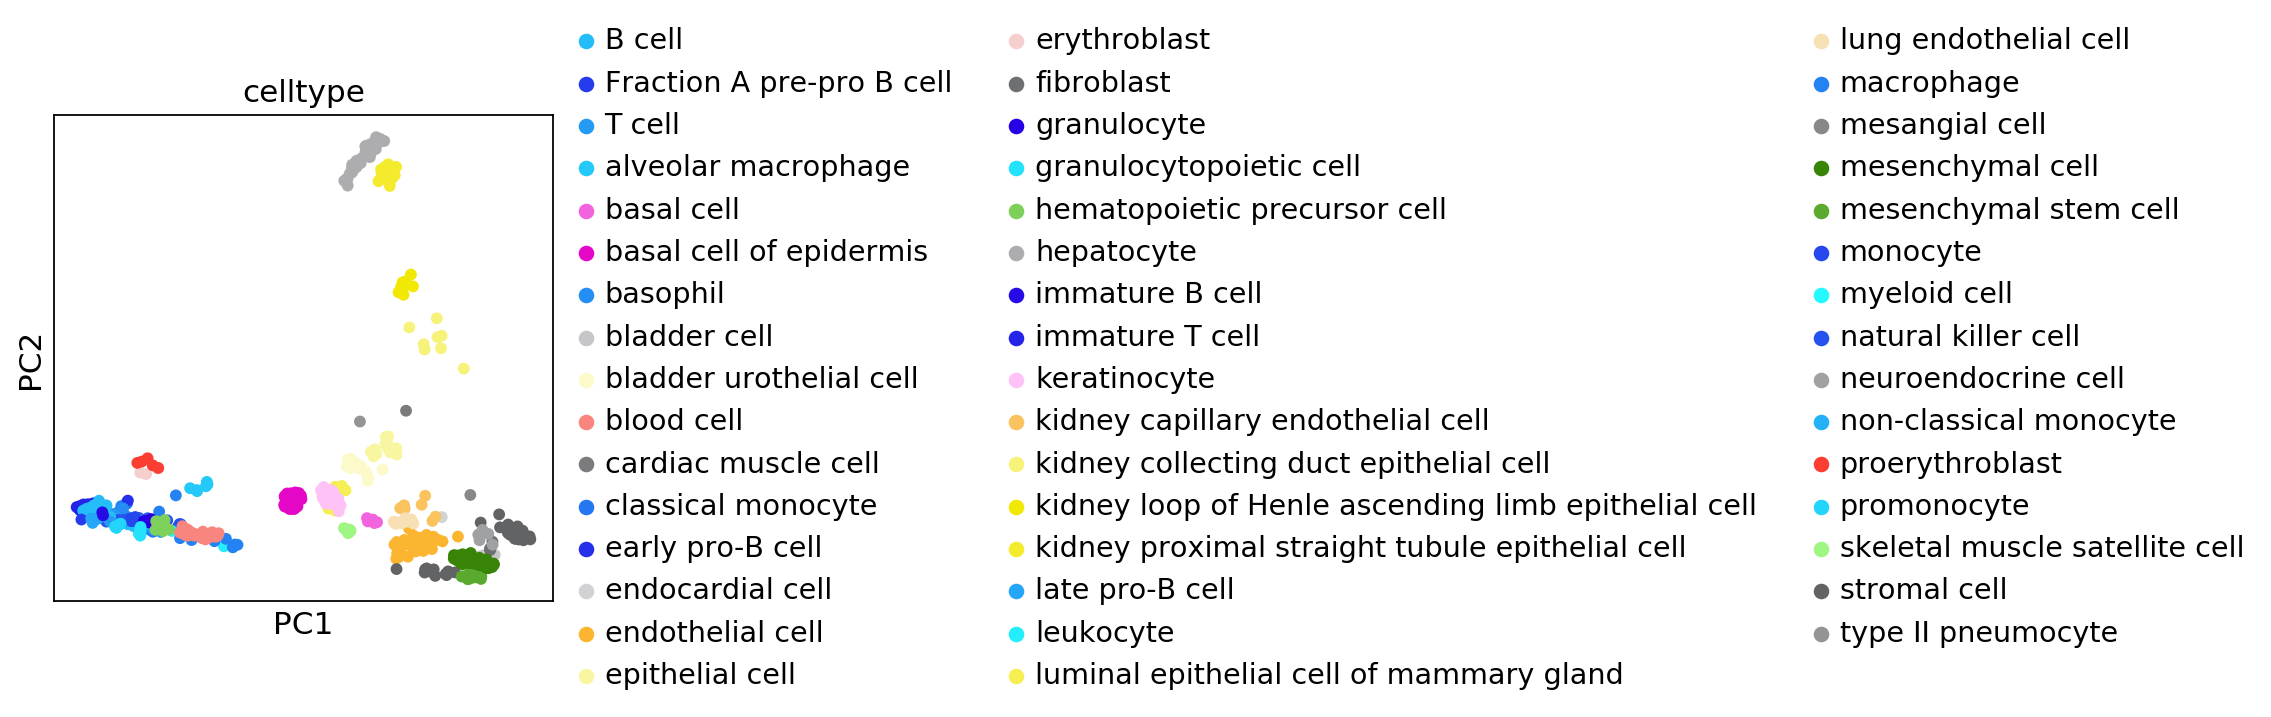

In [8]:
sc.pl.pca(droplet_pb, color='celltype')


In [9]:
sc.pp.neighbors(droplet_pb, n_neighbors=10, n_pcs=10)


In [10]:
sc.tl.umap(droplet_pb)


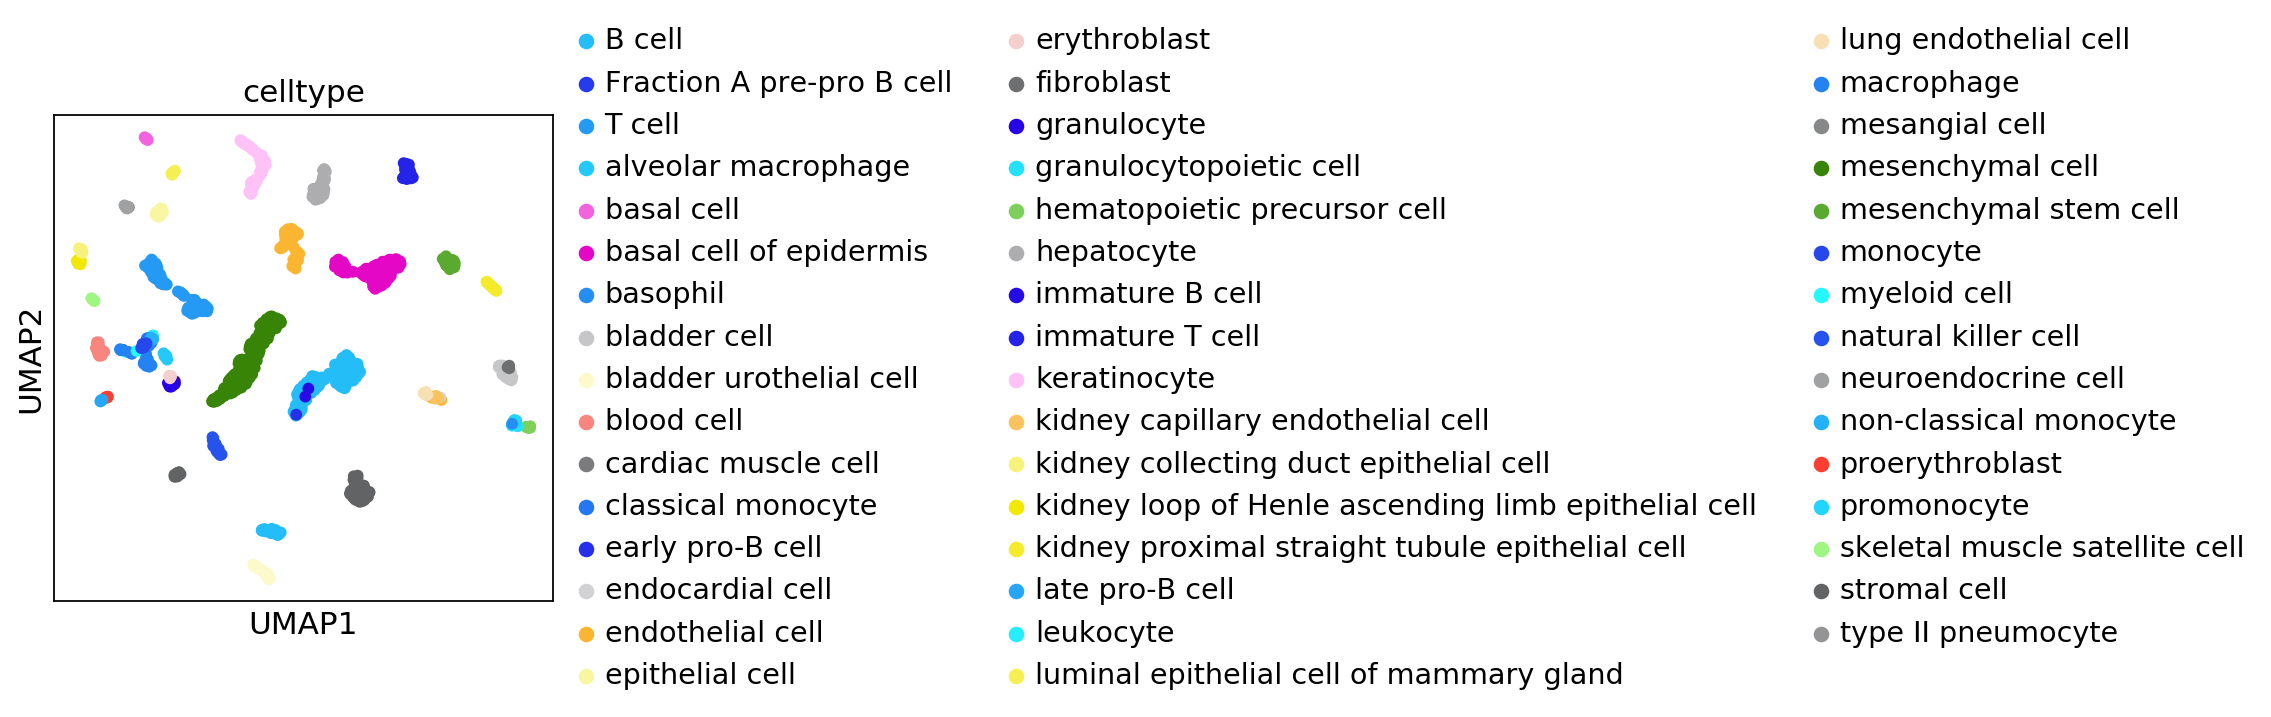

In [11]:
sc.pl.umap(droplet_pb, color=['celltype'])


# Regulon space

In [6]:
#Settings
DATA_FOLDER="/work/sduknn/Andreas/TM_MCA/database_SCENIC/tmp/droplet"
REGULONS_FNAME = os.path.join(DATA_FOLDER, "regulons_10_percent.p")
MOTIFS_FNAME = os.path.join(DATA_FOLDER, "motifs_10_percent.csv")

In [7]:
#Reload precomputed regulons
with open(REGULONS_FNAME, "rb") as f:
    regulons_drop = pickle.load(f)

In [8]:
#make expression matrix
ex_matrix = droplet_pb.X
ex_matrix = pd.DataFrame(data= ex_matrix,
                              index=pd.DataFrame(droplet_pb.obs.index.values),
                              columns=droplet_pb.var.index.values)
        
#calculate regulon AUC
droplet_auc_mtx = aucell(ex_matrix, regulons_drop, num_workers=24)

In [9]:
droplet_auc_mtx.to_csv('data/pb_droplet_auc_mtx.csv')

In [10]:
from RegulonAnalysis import RegulonsAnalysis

In [11]:
#initialize regulon object
droplet1 = RegulonsAnalysis( regulons_drop,  droplet_pb, droplet_auc_mtx)


/gpfs/gss1/work/sduknn/Andreas/notebooks/MCA_TM/SCENIC/Final_notebooks/5_Regulon_analysis/RegulonAnalysis.py:470: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  if 'X_pca' in  self.regulon_scanpy.obsm:


PCA not computed - using 5 principal components


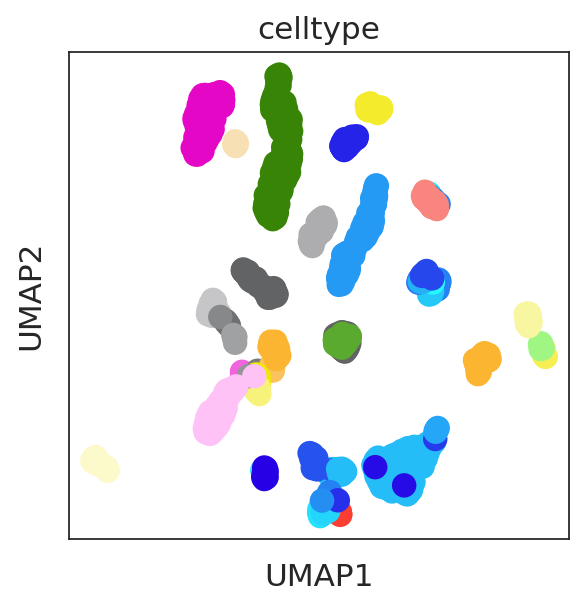

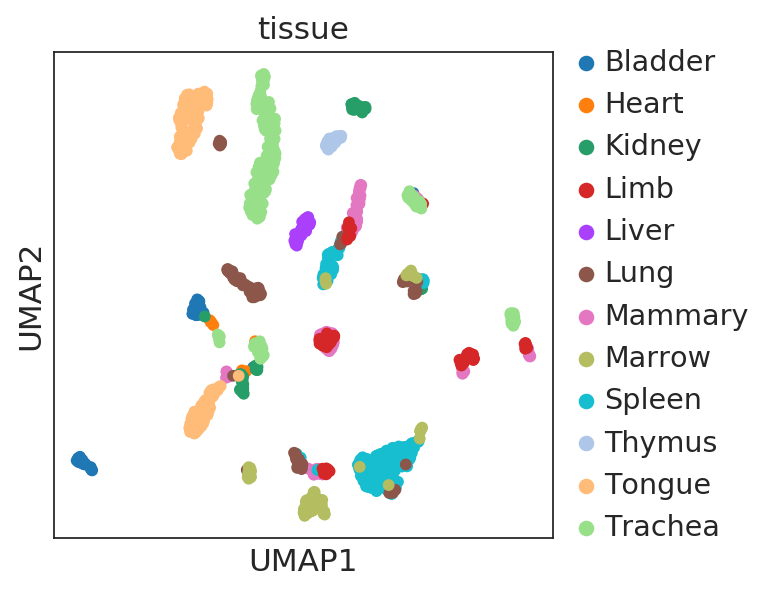

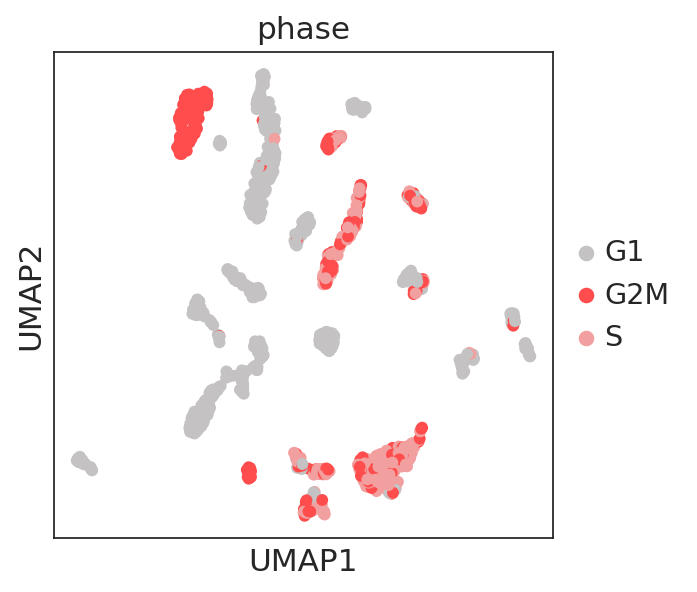

In [18]:
droplet1.plot('umap', 'celltype', color_index=colormap, pcs= 5, color_index_type='color_grad')
droplet1.plot('umap', 'tissue', color_index=colormap, pcs= 5, color_index_type='color_grad')
droplet1.plot('umap', 'cellcycle', color_index=colormap, pcs= 5, color_index_type='color_grad')

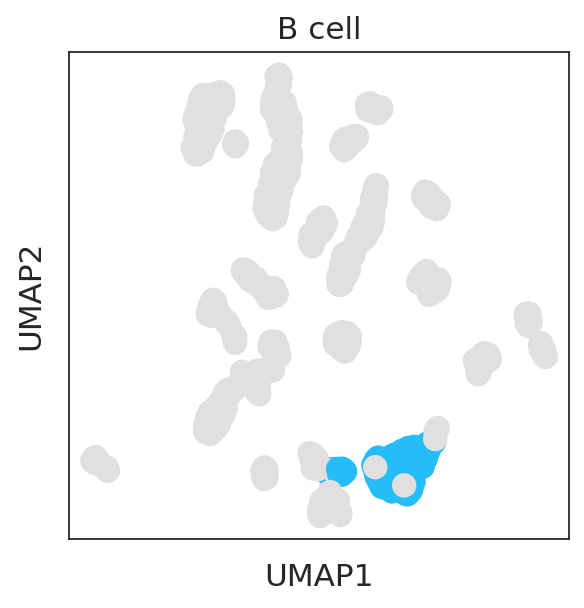

In [19]:
droplet1.plot_by_celltype_ind(Type='B cell',dr ='umap', color_index=colormap, pcs= 5)

Plot a few regulon activities

## Cell to cell correlation based on RAS

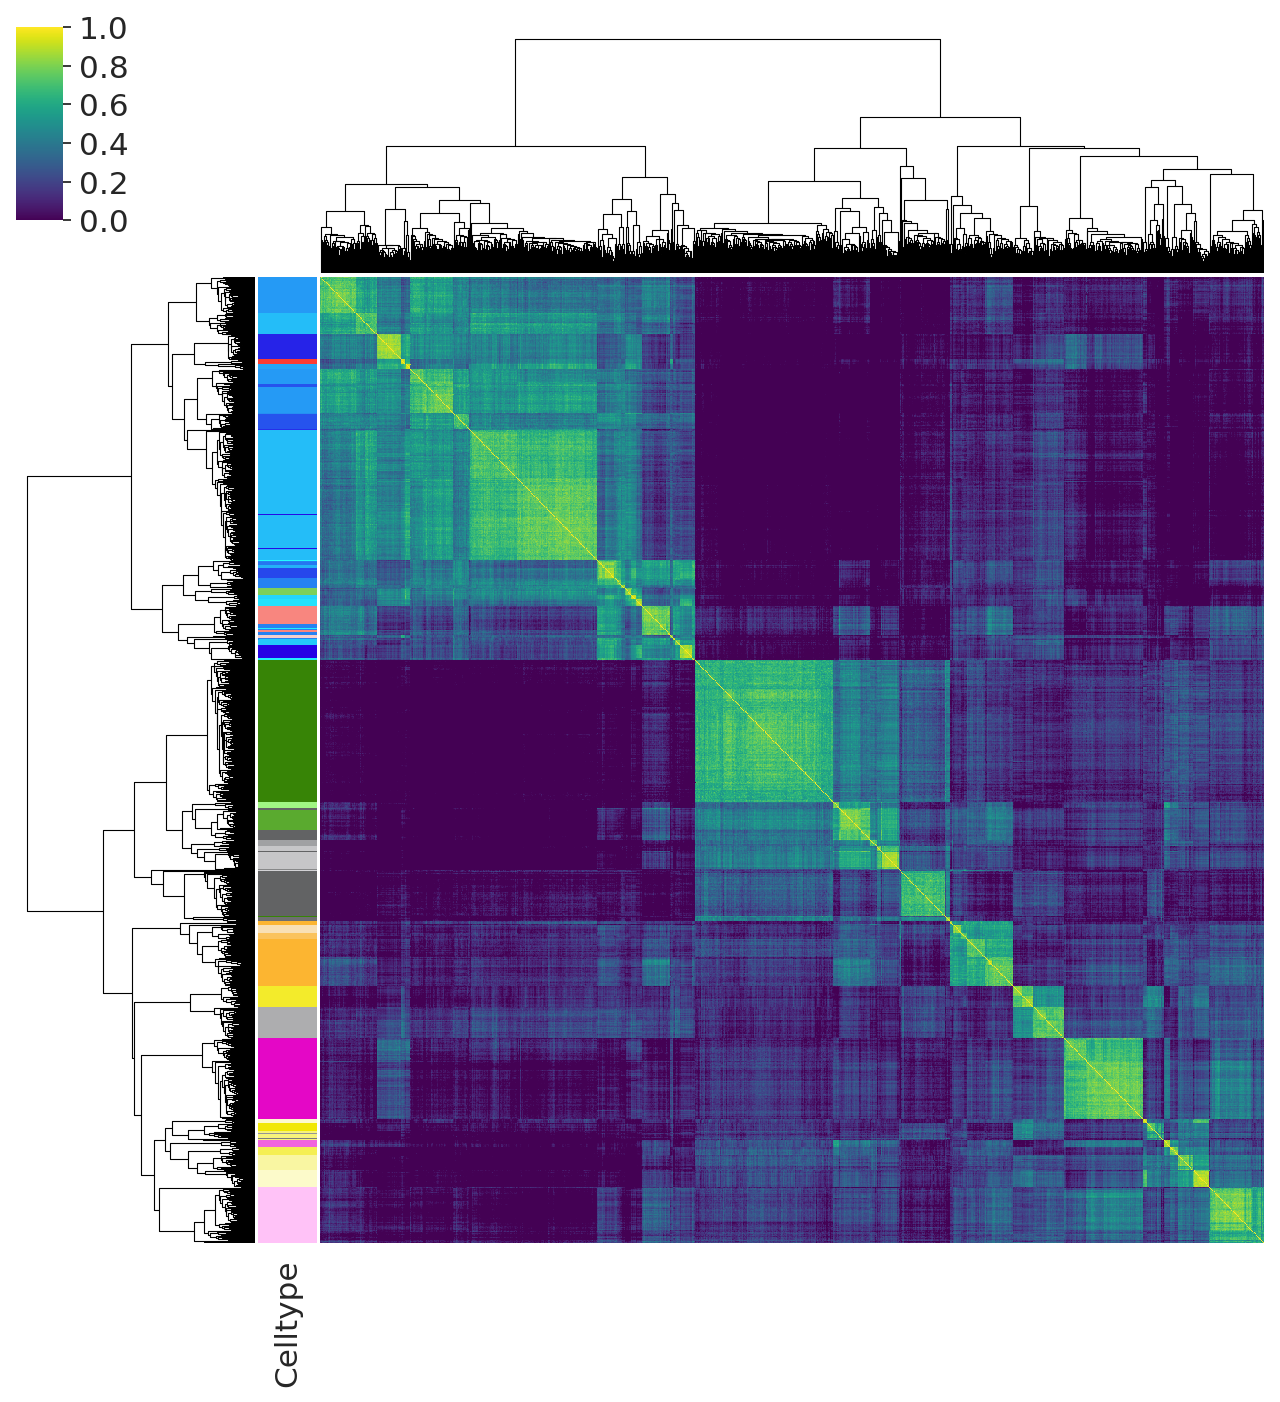

In [41]:
#remember to calculate tsne with celltypes before. Or else, celltype_colors will not be stored in the scanpy object
droplet1.cell_regulon_cor(color_index = colormap, color_by='color_grad')


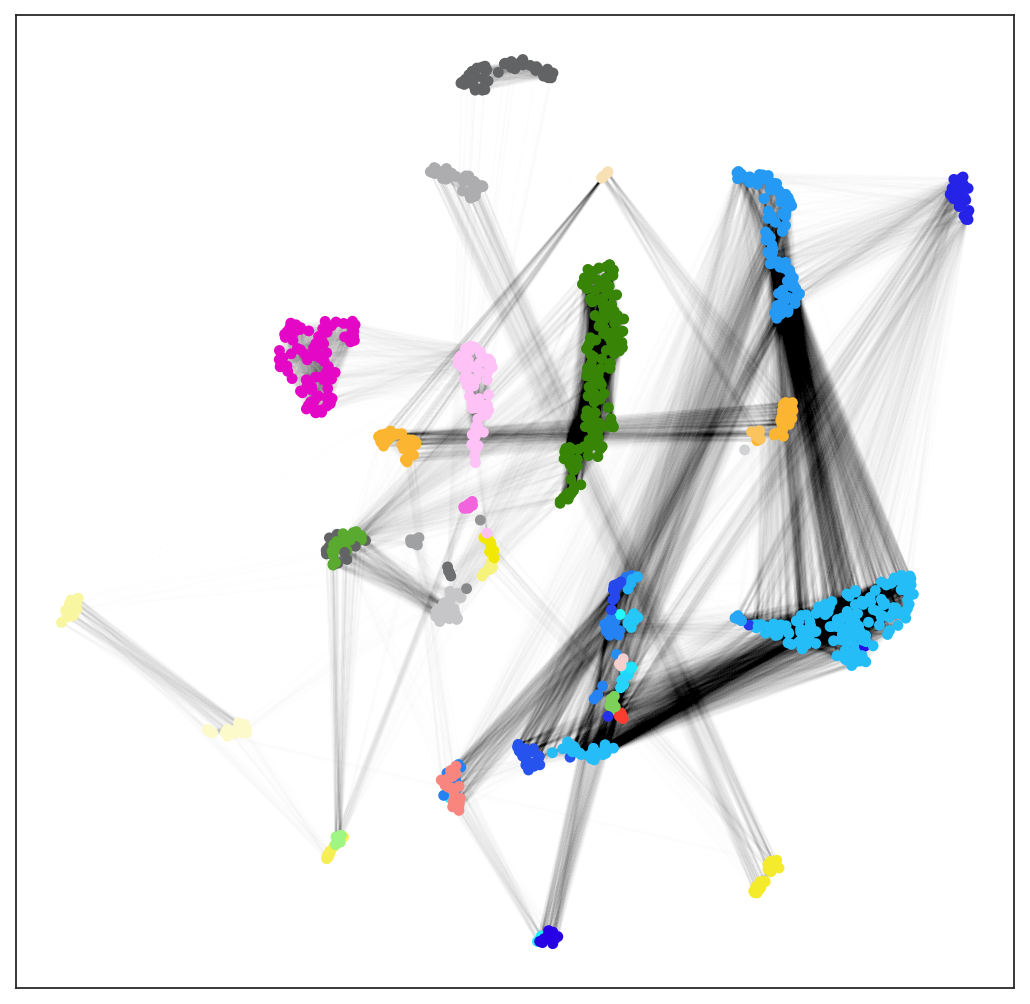

In [24]:
droplet1.cell_regulon_network(0.50, color_index = colormap, dr='umap', pcs=5, color_by = 'color_grad', save = 'data/pseudobulk_tsne_droplet.gexf')

/home/andreas/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


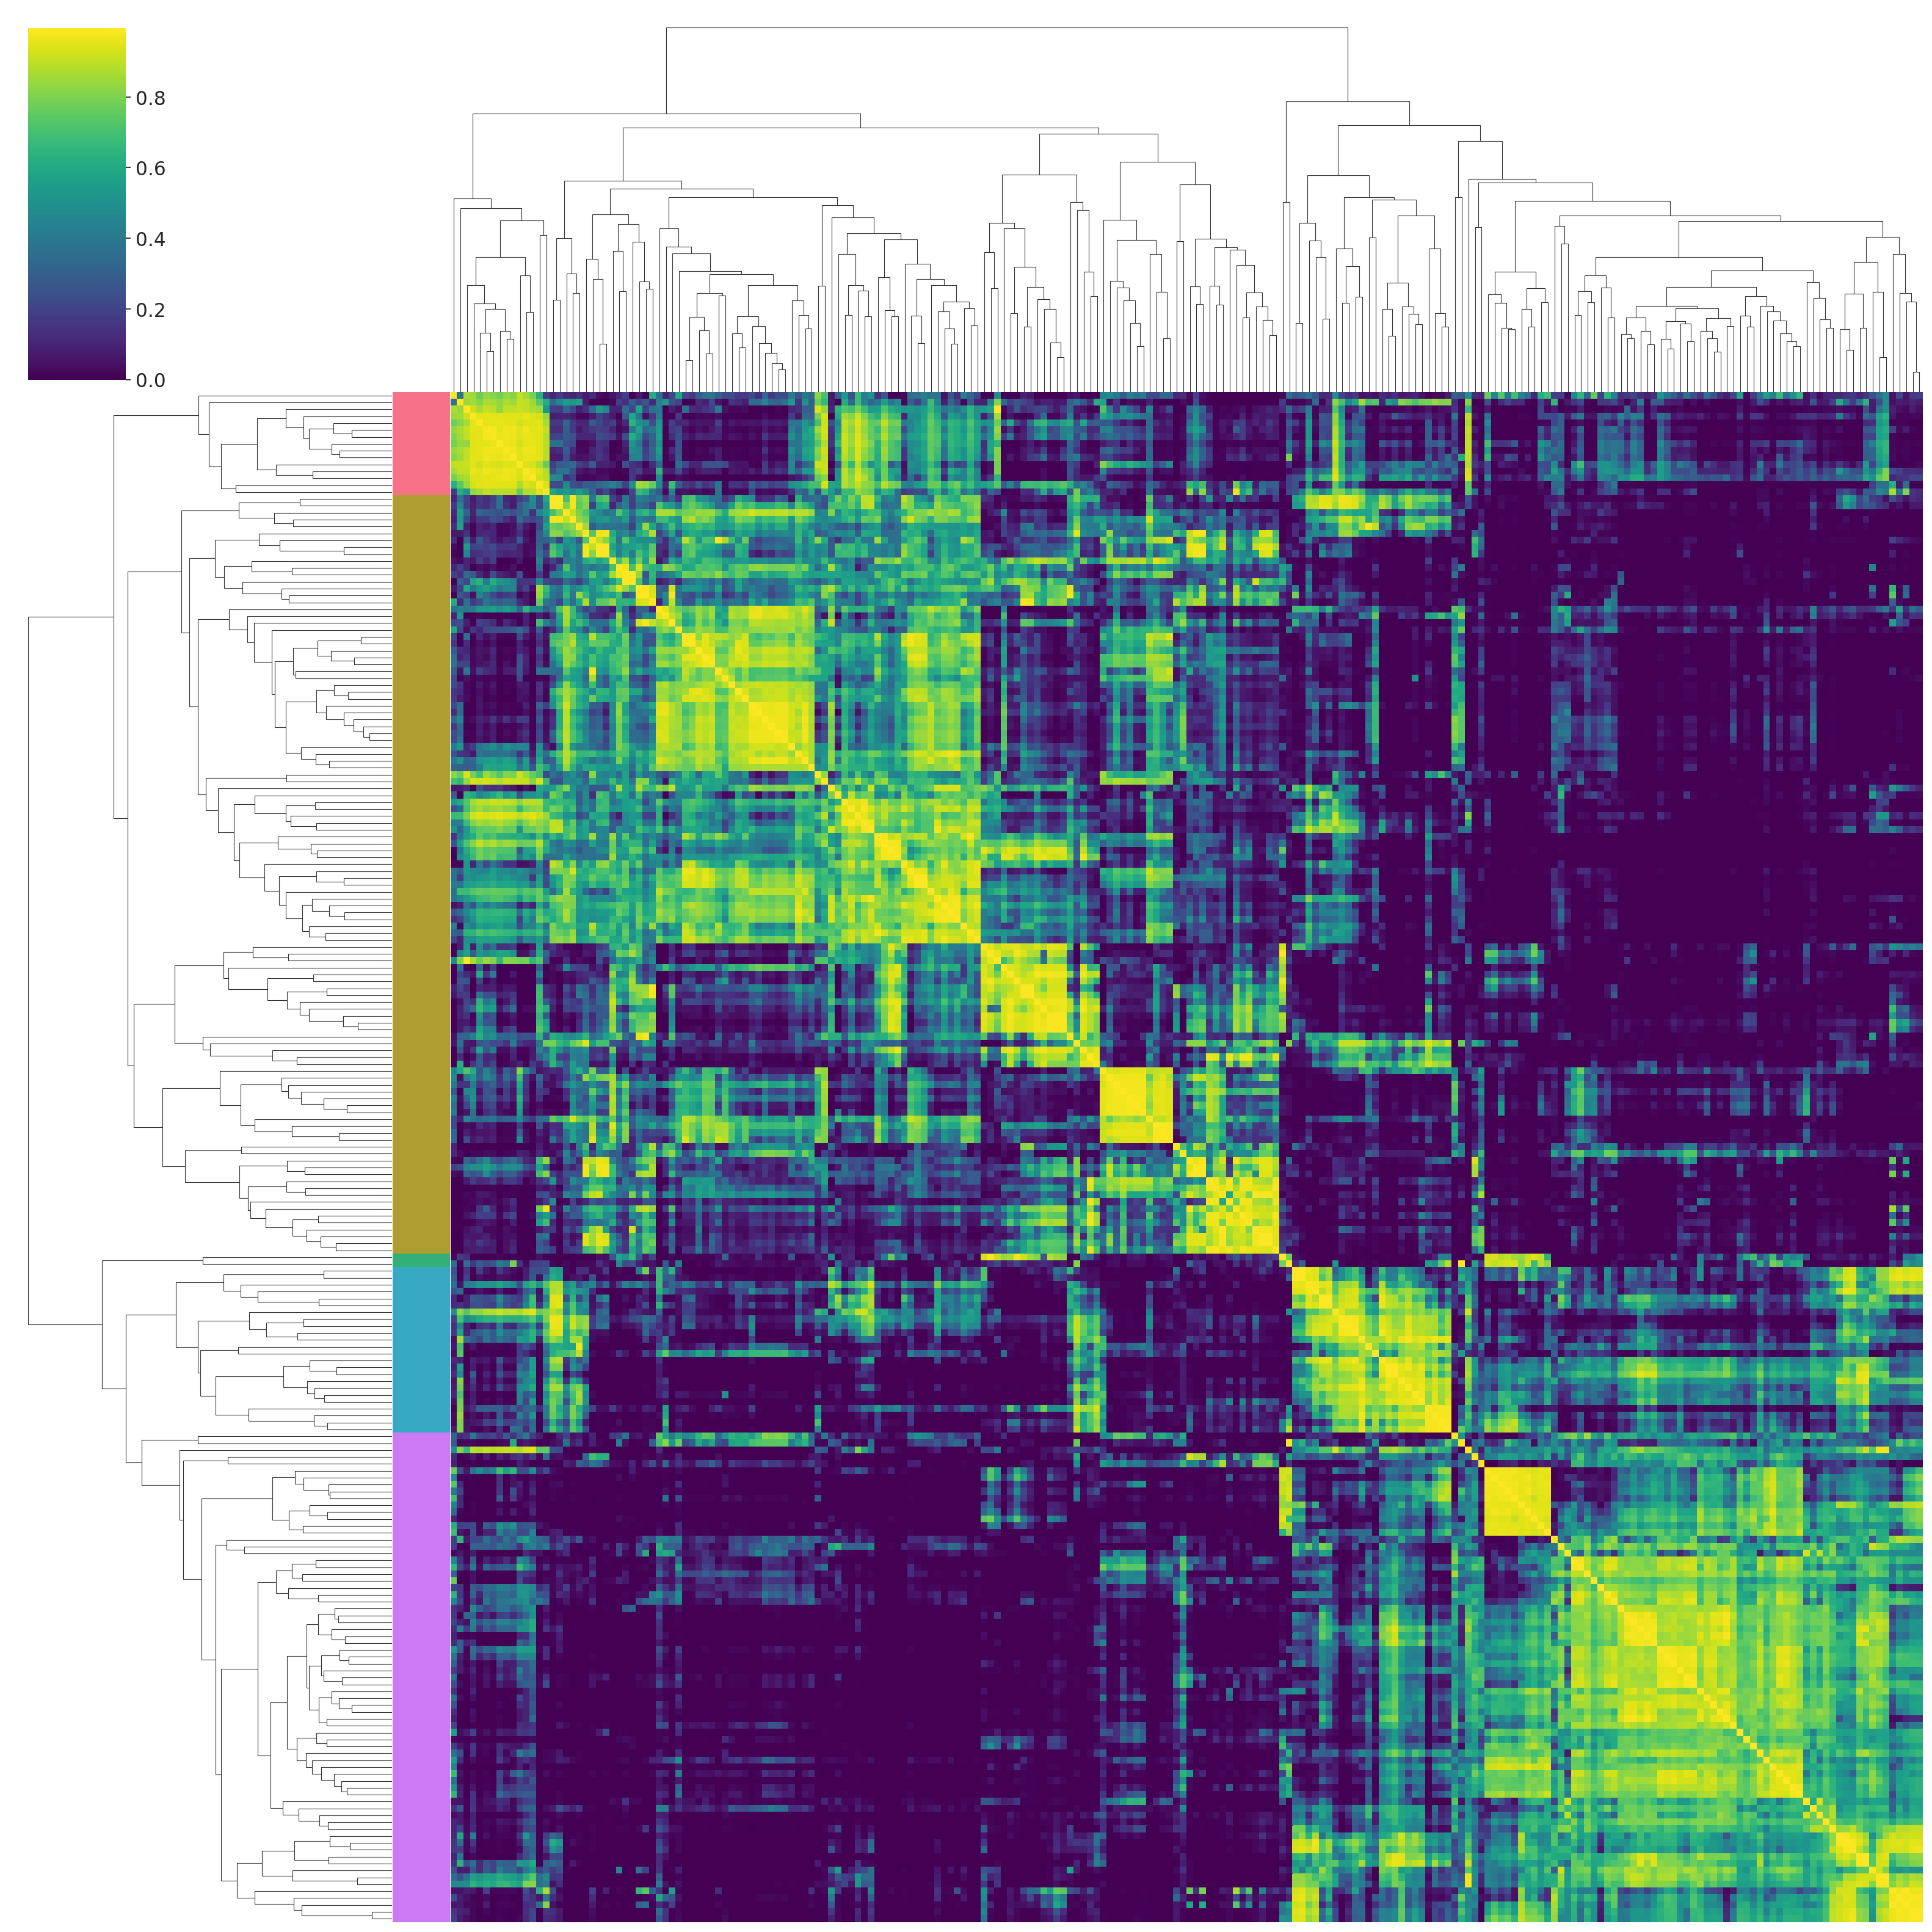

In [25]:
droplet1.plot_csi()




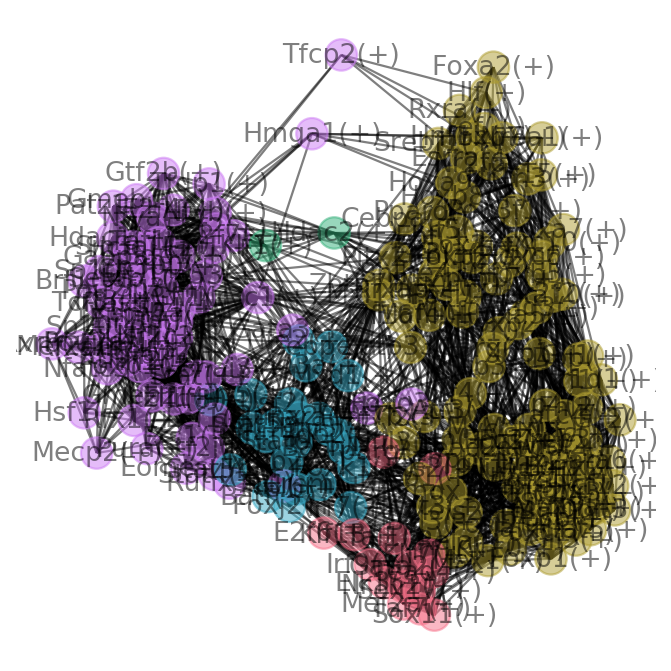

In [26]:
droplet1.regulon_network(0.70, save = 'data/regulon_network_droplet_pseudobulk_5clust.gexf', lut=None)


# single-cell cleaning

In [12]:
droplet = sc.read('data/tm_droplet_scanpy_no_processing.h5ad')

In [13]:
#Number of cells before processing
print(droplet.n_obs)

70118


In [14]:
droplet.obs['celltype'] = droplet.obs['cell_ontology_class']

Remove cells not annotated by author

In [15]:
droplet.obs['cell_ontology_class'].replace(np.NaN, 'Non-annotated', inplace = True)


In [16]:
droplet = droplet[droplet.obs['cell_ontology_class'] != 'Non-annotated']

In [17]:
droplet.obs['celltype'] = droplet.obs['cell_ontology_class']
droplet = droplet[droplet.obs['celltype'] != 'unassigned']
droplet.obs['original_annotation'] = droplet.obs['cell_ontology_class']

droplet = droplet[[type(i) == str for i in droplet.obs['celltype']]]

In [18]:
droplet.obs['n_counts'] = droplet.X.sum(axis=1).A1
sc.pp.calculate_qc_metrics(droplet, inplace = True)

In [19]:
from RegulonPreprocessing import stats

In [20]:
stats([droplet], ['TM-10X'])

TM-10X
# Tissues             12.000000
Mean Counts         7728.101074
Median Counts       4893.000000
Mean Genes          1915.669152
Median Genes        1619.000000
Author cell-types     55.000000
Cells              54865.000000

In [21]:
#library size normalization
sc.pp.normalize_per_cell(droplet, counts_per_cell_after=1e4)

#log transform
sc.pp.log1p(droplet)

In [22]:
mito_genes_drop = droplet.var_names.str.startswith('Mt')

In [23]:
droplet.obs['percent_mito'] = np.sum(
    droplet[:, mito_genes_drop].X) / np.sum(droplet.X)

In [24]:
droplet.obs['n_counts'] = droplet.X.sum(axis=1).A1

In [25]:
sc.pp.filter_genes(droplet, min_counts=1)


In [26]:
droplet.obs['protocol'] = '10X'

In [27]:
from RegulonPreprocessing import score_cell_cycle
score_cell_cycle(droplet)

In [28]:
droplet_auc_mtx = pd.read_csv('data/droplet_auc_mtx.csv', index_col = 0)

In [29]:
droplet.X = droplet.X.todense()

In [30]:
droplet_all = RegulonsAnalysis( regulons_drop,  droplet, droplet_auc_mtx)


PCA not computed - using 10 principal components


... storing 'protocol' as categorical
... storing 'phase' as categorical


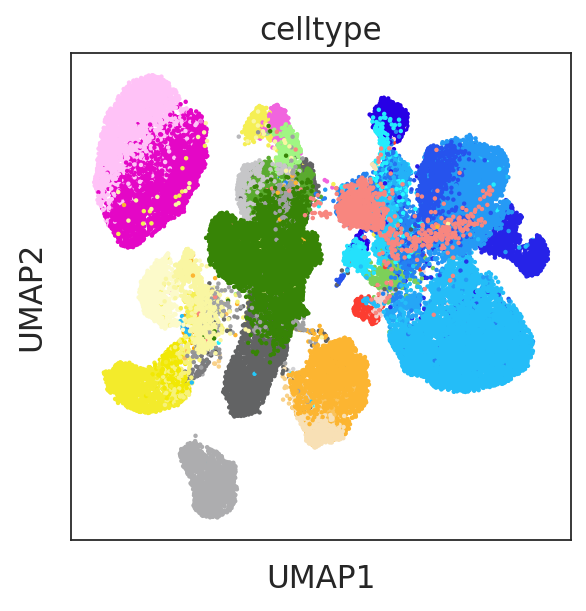

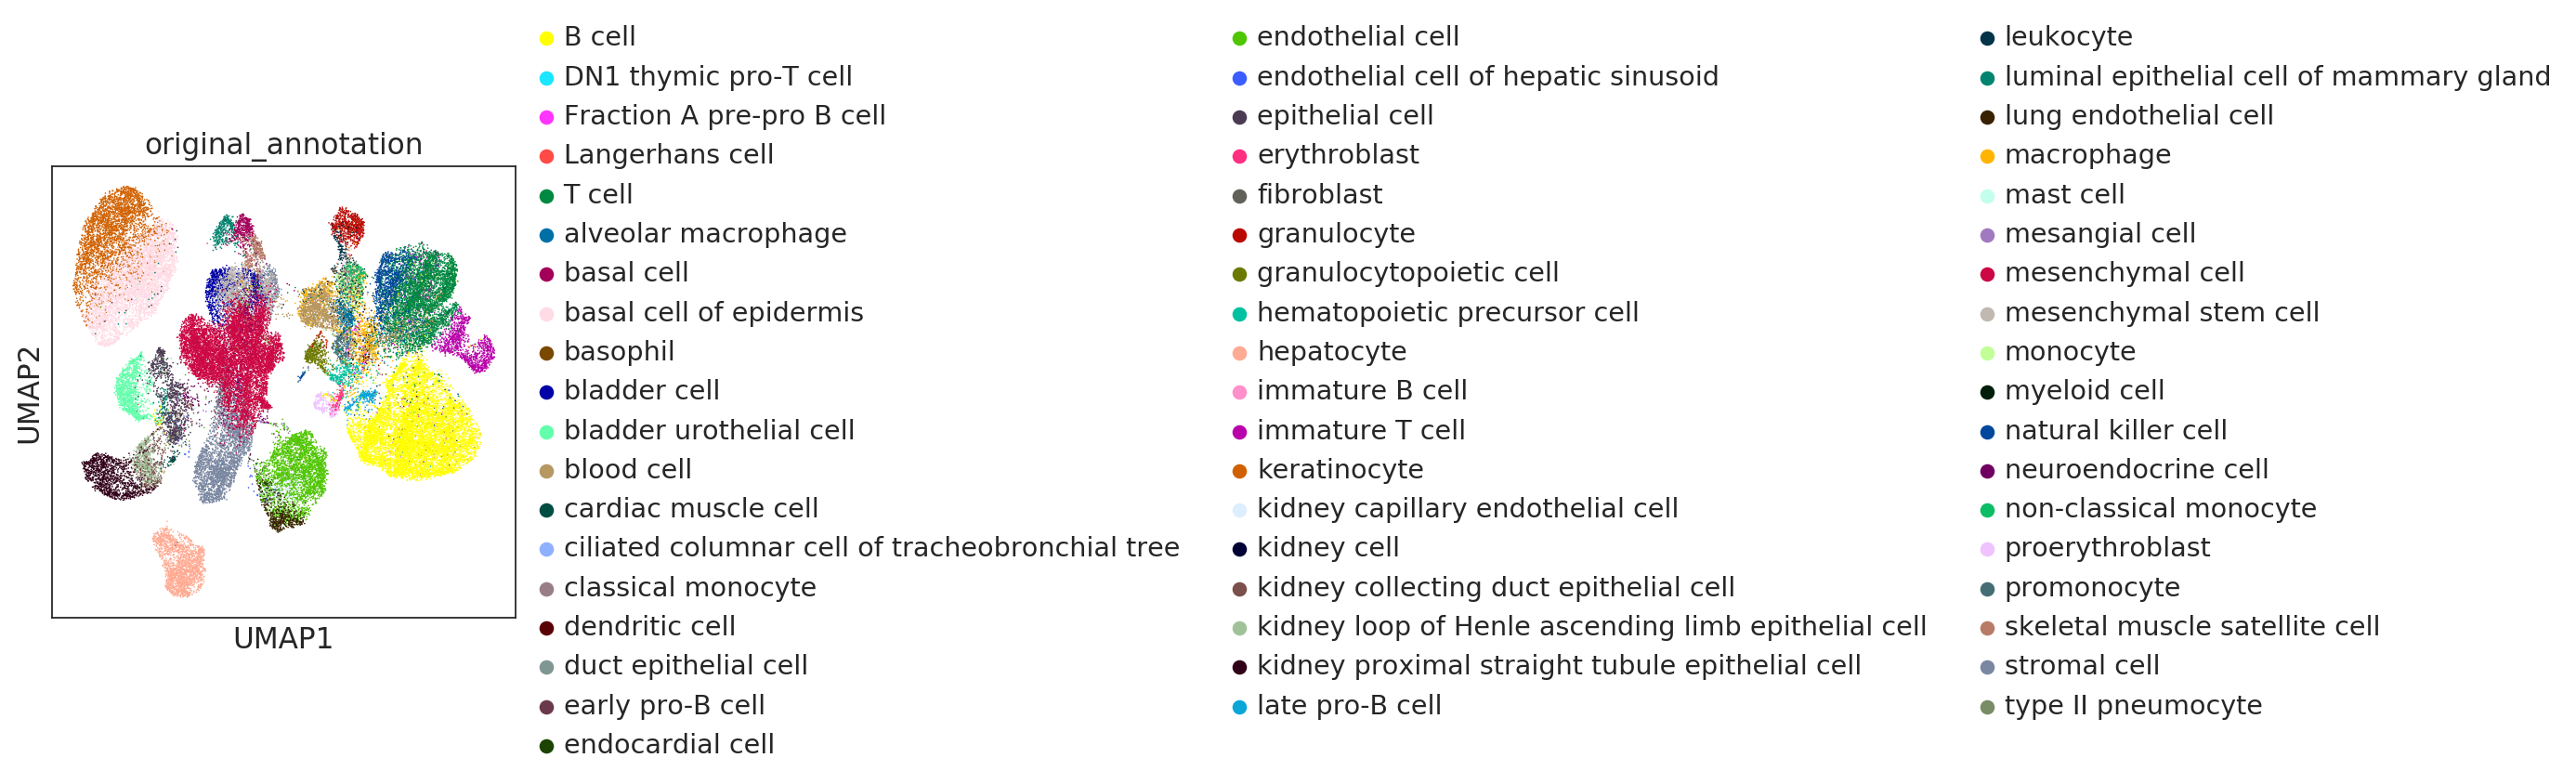

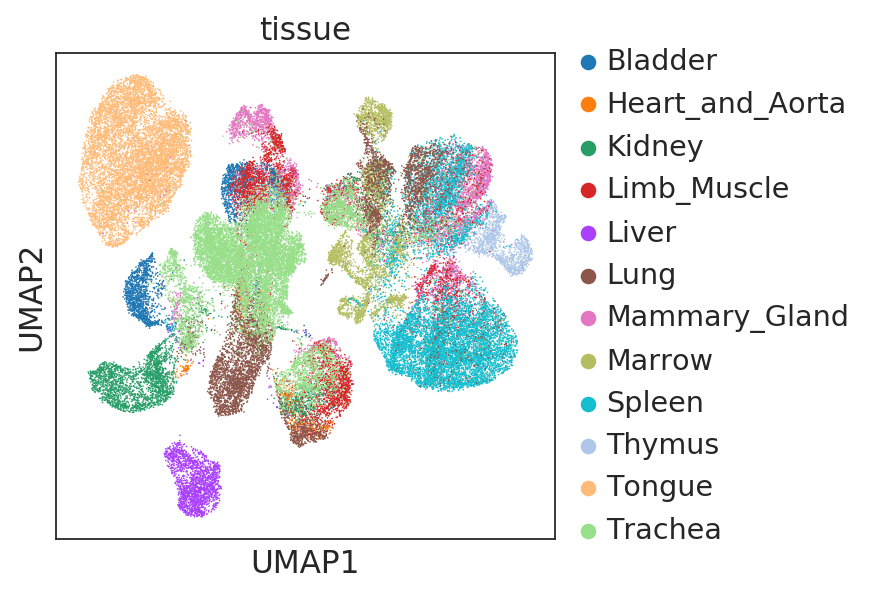

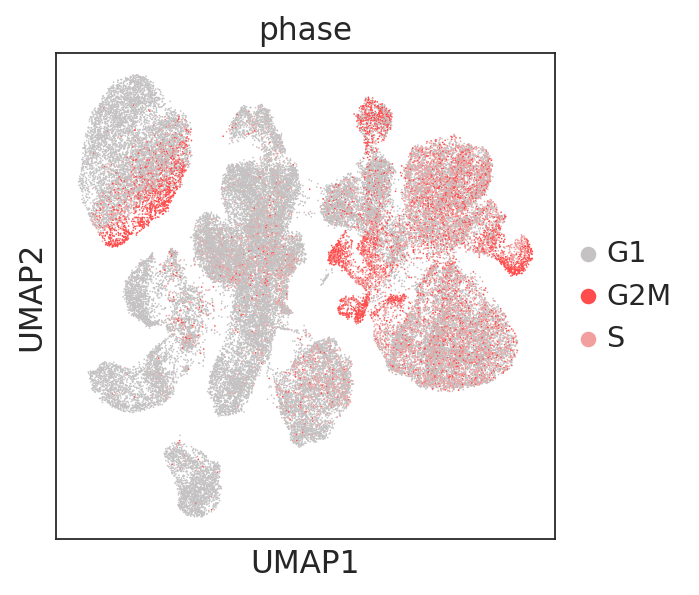

In [56]:
droplet_all.plot('umap', 'celltype', color_index=colormap, pcs= 10, color_index_type='color_grad', point_size = 1)
droplet_all.plot('umap', 'original_annotation', color_index=colormap, pcs= 10, color_index_type='color_grad', point_size = 1)
droplet_all.plot('umap', 'tissue', color_index=colormap, pcs= 10, color_index_type='color_grad')
droplet_all.plot('umap', 'cellcycle', color_index=colormap, pcs= 10, color_index_type='color_grad')

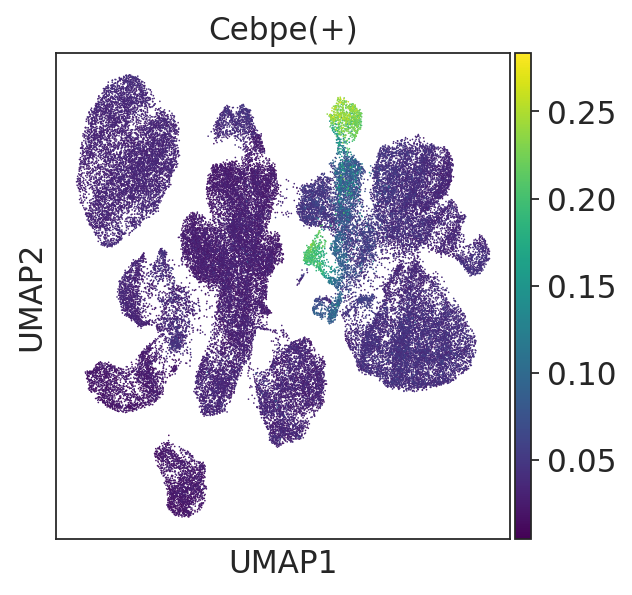

In [57]:
droplet_all.plot('umap', 'Cebpe(+)', color_index=colormap, pcs= 5)


## Regulon specificity

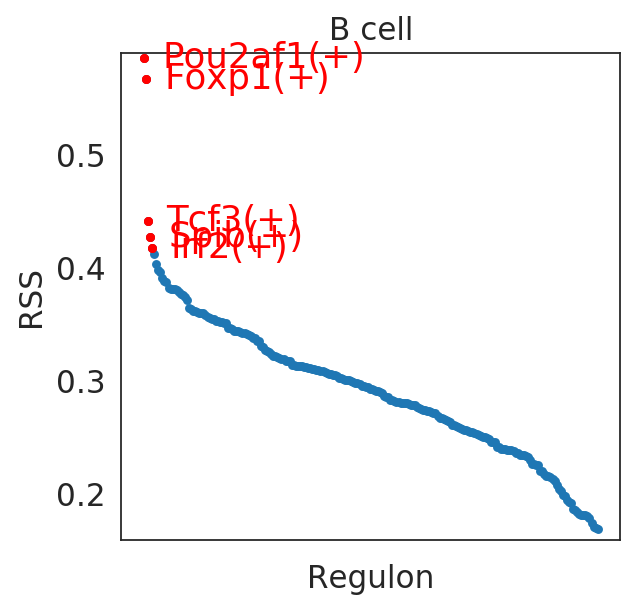

In [58]:
droplet_all.plot_regulon_specificity_celltype('B cell')

### Compare AUCell to VIPER regulon scoring

In [47]:
df = pd.read_csv('data/droplet_auc_mtx.csv', index_col = 0)

In [48]:
df.index = [x.split("""'""")[1] for x in df.index]
df.columns =  [x.split("""(""")[0] for x in df.columns]
rss = droplet1.rss
rss.columns =  [x.split("""(""")[0] for x in rss.columns]
df = df.loc[df.index]
df['celltype'] = droplet.obs.cell_ontology_class

In [61]:
viper = pd.read_csv('VIPER_result.tsv', sep = ' ').dropna()
viper.index = viper.Regulon

In [120]:
df = pd.concat([viper, auc.T], axis = 1).dropna()[['NES', 'B cell']]
df.columns = ['Viper', 'AUCell']

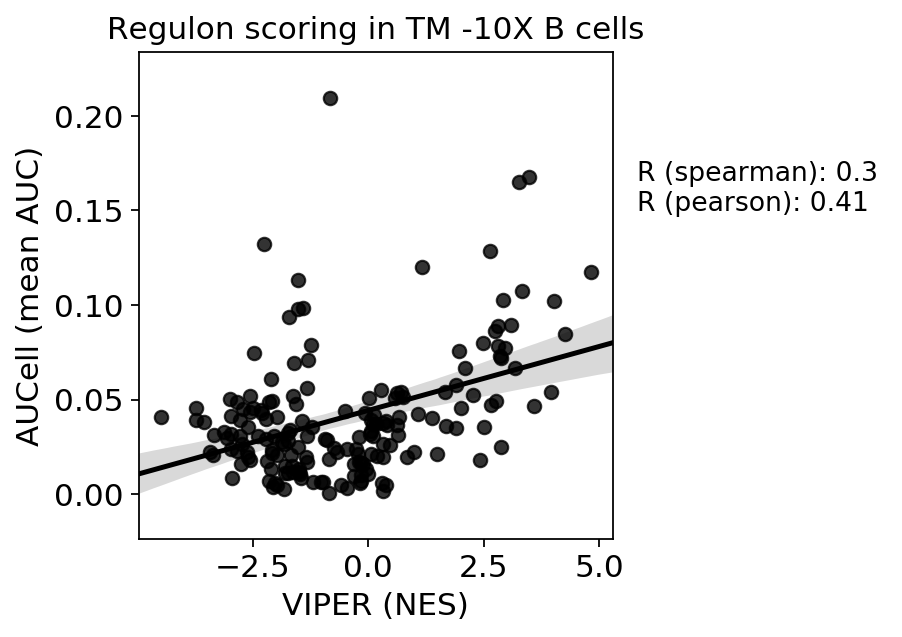

In [121]:
spear_corr = df.corr(method = 'spearman').iloc[1,0]
pears_corr = df.corr().iloc[1,0]

plt.figure(figsize = (8,4))
sns.regplot(x = 'Viper', y = 'AUCell',data = df, color = 'k')
plt.grid(False)
plt.title('Regulon scoring in TM -10X B cells')
plt.ylabel('AUCell (mean AUC)')
plt.xlabel('VIPER (NES)')

plt.subplots_adjust(right=0.55)
left, right = plt.xlim() 
plt.text(right * 1.1, 0.15,'R (spearman): {} \nR (pearson): {}'.format(round(spear_corr, 2), round(pears_corr, 2)), fontsize=12)

plt.savefig('Fig/viper_AUC.pdf')

In [122]:
df = pd.concat([viper, rss.T], axis = 1).dropna()[['NES', 'B cell']]
df.columns = ['Viper', 'rss']

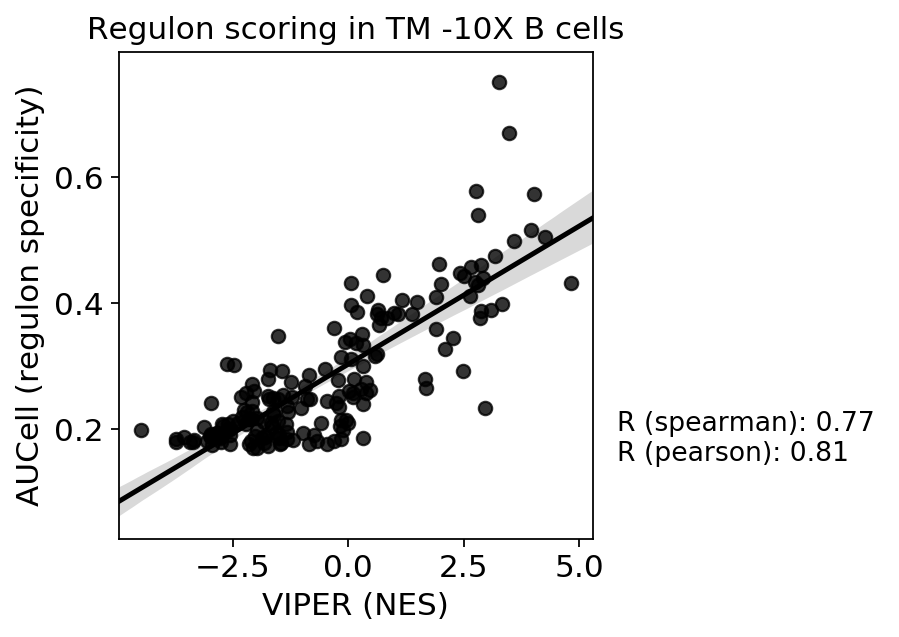

In [123]:
spear_corr = df.corr(method = 'spearman').iloc[1,0]
pears_corr = df.corr().iloc[1,0]


plt.figure(figsize = (8,4))
sns.regplot(x = 'Viper', y = 'rss',data = df, color = 'k')
plt.grid(False)
plt.title('Regulon scoring in TM -10X B cells')
plt.ylabel('AUCell (regulon specificity)')
plt.xlabel('VIPER (NES)')

plt.subplots_adjust(right=0.55)
left, right = plt.xlim() 
plt.text(right * 1.1, 0.15,'R (spearman): {} \nR (pearson): {}'.format(round(spear_corr, 2), round(pears_corr, 2)), fontsize=12)

plt.savefig('Fig/viper_auc_rss.pdf')